In [2]:
from IPython.display import Image
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from fboost import outlier_iqr, DataPreparator, FeatureBoosterRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from ffx import FFXRegressor

import warnings
warnings.filterwarnings('ignore')

# Set a seed value
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


# Demonstrating the power of feature engineering - part II: How I beat XGBoost with a Linear Regression

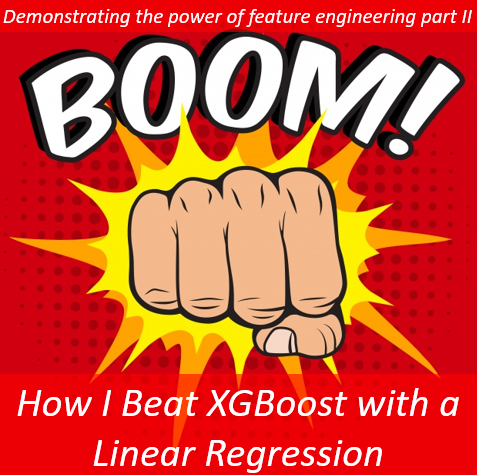

In [3]:
Image("Boom.png", width=350, height=350)

##### Yes, you read correctly!

In this article, I will show you how to beat the notorious XGBoost with a simple Linear Regression model using a goddamn good feature engineering step! 

For this experimentation, I will use the popular Kaggle open dataset “Medical Cost Personal Insurance Forecast”. This is a dataset with 7 features and around 1338 rows in it. It is a multivariate regression problem that seems “non linear” at first.

If you have read the first part: 
<a href="https://github.com/CoteDave/blog/blob/master/Demonstrating%20the%20power%20of%20feature%20engineering/Demonstrating%20the%20power%20of%20feature%20engineering%20-%20Part%20I.ipynb    ">Demonstrating the power of feature engineering – Part I</a>

I explained that Feature engineering is often under-estimated in a machine-learning project. Many Data Science practitioners will go through this step too rapidly claiming they “know” their data or that the dataset is “already optimal” with all the relevant business features. Sometimes, going forward with a more complex model or skipping the feature engineering step to hyper-parameters tuning is not always the best move to make.

I will demonstrate this thinking again, but this time, using a more complex and multivariate dataset and at the end, getting a better performance with a linear model than with an XGBoost model!

All the python code to my complete solution will be available to public.

## Table of Contents
- Understanding the problem statement and dataset
- Quick exploratory data analysis (EDA)
- Data preparation
- Linear Regression vs XGBoost BEFORE feature engineering
- Implementing the feature engineering strategy
- Linear Regression vs XGBoost AFTER feature engineering
- Conclusion




## Understanding the problem statement and dataset

First of all, let’s have a look at the original dataset: 

In [4]:
dataset = pd.read_csv('insurance_kaggle.csv', sep = ',') 
dataset.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
dataset.shape

(1338, 7)

Description of the features:
    
- **age:** age of primary beneficiary
- **sex:** insurance contractor gender, female, male
- **bmi:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- **children:** Number of children covered by health insurance / Number of dependents
- **smoker:** Smoking
- **region:** the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- **charges:** Individual medical costs billed by health insurance. This is the target that we want to forecast

I took this data dictionary from 
<a href="https://www.kaggle.com/mirichoi0218/insurance">kaggle_dataset_description_link</a>

If you go to this link, you can also have an interactive visualization of the dataset.

If you want to do some expriments, the dataset is also available here: 
<a href="https://github.com/stedy/Machine-Learning-with-R-datasets">dataset_download_link</a>

The problem statement is: **Can you accurately predict insurance costs (charges) ?**


## Quick exploratory data analysis (EDA)
We can do some Exploratory Data Analysis (EDA) to understand the relationships in the data. 

**The goal of this article is not to do EDA soo I will go short with the explanations:**

In [7]:
y_colname = 'charges'

###### CATEGORICAL vs NUMERICAL
colnames_numerical = dataset.select_dtypes(include=[np.number]).columns.tolist()
colnames_categorical = dataset.select_dtypes(include='object').columns.tolist()

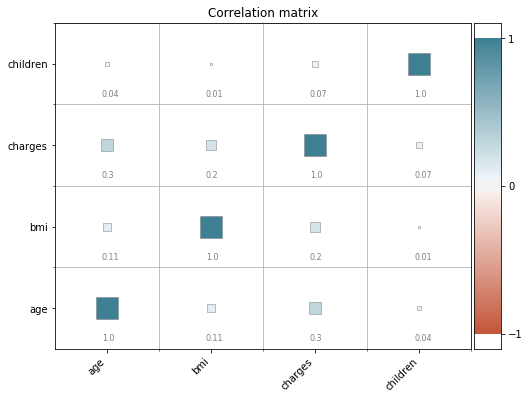

In [8]:
###### CORRELATION MATRIX - CUSTOMIZED HEATMAP FUNCTION
def heatmap(x, y, size, color, figsize=(15,15), corr_label_size = 6.5):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]
    
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    
    x_vals = list(x.map(x_to_num))
    y_vals = list(y.map(y_to_num))
    txt = round(color, 2).astype(str).tolist()
    for i,typ in enumerate(txt):
        ax.scatter(
            x=x_vals[i], # Use mapping for x
            y=y_vals[i], # Use mapping for y
            s=size[i] * size_scale, # Vector of square sizes, proportional to size parameter
            c=color[[i]].apply(value_to_color), # Vector of square colors, mapped to color palette
            edgecolors='grey',
            linewidths=0.5,
            marker='s' # Use square as scatterplot marker
        )
        ax.text(x_vals[i]-0.05, y_vals[i]-0.4, typ, fontsize = corr_label_size, color = 'grey')
    ax.set_title('Correlation matrix')
  
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major') # Turn off major gridlines
    ax.grid(True, 'minor') # Turn on minor gridlines
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True) # Set gridlines to appear between integer coordinates
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True) # Do the same for y axis
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
       
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = y[1] - y[0]
    ax.barh(
        y=y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(y), max(y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 

###### CORRELATION MATRIX PLOT - ONLY NUMERICAL
corr = dataset[colnames_numerical].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value'],
    figsize=(8,6), 
    corr_label_size = 8
)

In this correlation matrix (numerical features only), if you look at the predicator column (charges), we already see that features "age" and "bmi" have the biggest positive correlations with charges.

If you are interested in this heatmap vizualisation function, I took the original code from here:
<a href="https://github.com/drazenz/heatmap/blob/master/Circle%20heatmap.ipynb">github_original_heatmap_function</a>
 
from there, I added some custom codes of mine to: 
- Show the correlation label
- Draw an edgeline around the squares
- Choose the proper figsize
- Choose the correlation label size

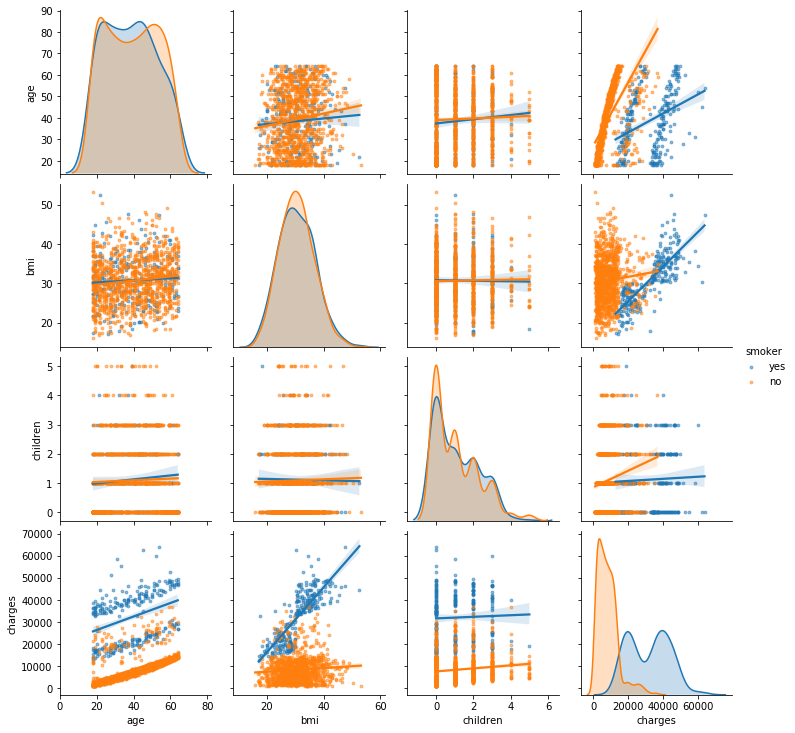

In [9]:
####Pairplot with numerical features (Before the dummy encoding):
sns.pairplot(dataset, 
             hue="smoker", 
             kind='reg', 
             plot_kws={'scatter_kws': {'alpha': 0.5, 's':8}})

There is a lot oh things happening in this pairplot. 
*the blue = smoker and orange = non-smoker. 

- **Smoker**: We can already see that the smoker categorical feature have a big impact on charges; it makes clear clusters where smoker have a higher charges than non-smoker.
- **Age**: The more aged, the more charges
- **Bmi and smoker**: the more bmi for smokers, the more charges

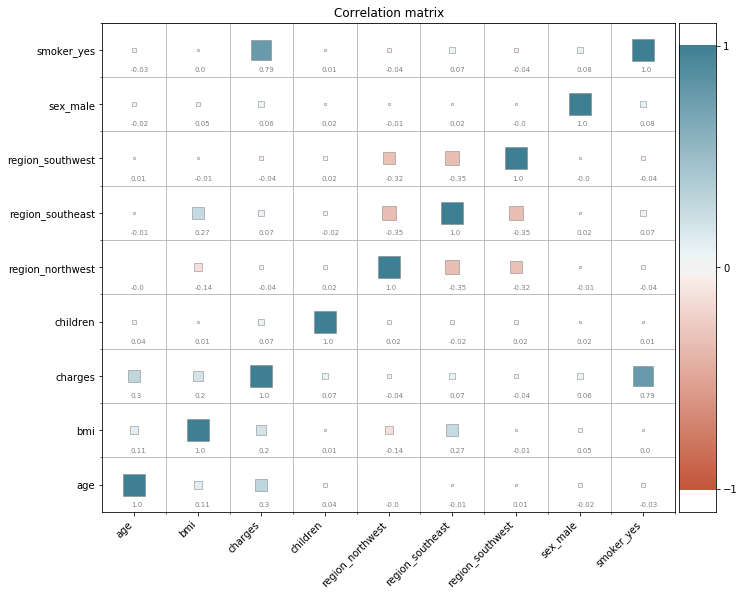

In [10]:
#Let dummy encode the categorical features and plot the correlation matrix again and see if smoker have a big impact
###### CORRELATION MATRIX PLOT - ONLY NUMERICAL
corr = pd.get_dummies(dataset, drop_first = True).corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value'],
    figsize=(11,9),
    corr_label_size = 7
)

In this new correlation matrix (with the converted categorical features to numerical), we can see that "smoker_yes" have a HUGE positive correlation on charges.

We can also see that there is some multicollinearity between the regions, and bmi vs regions.

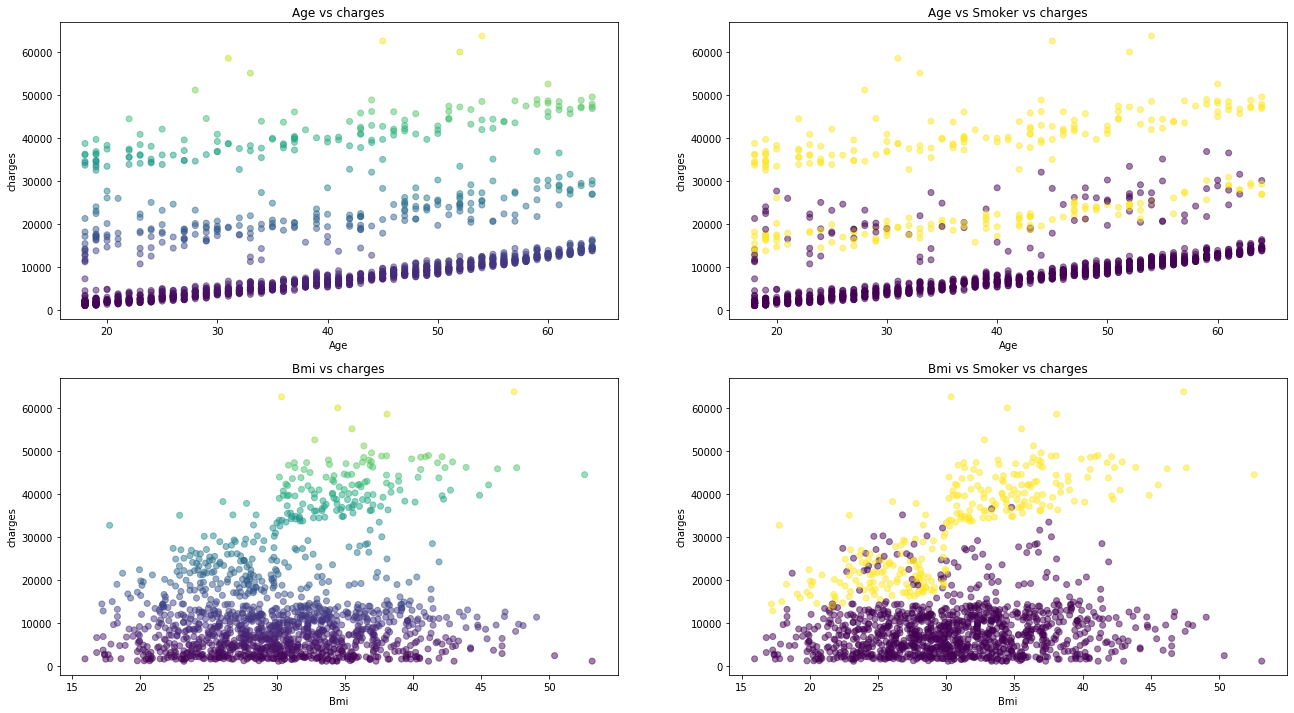

In [11]:
#### Bivariate and Trivariate analysis
###### Bi-Tri-Variate plot
f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(22, 12));
ax1.set_title('Age vs ' + y_colname);
ax1.set_ylabel(y_colname);
ax1.set_xlabel('Age');
ax2.set_title('Age vs Smoker vs ' + y_colname);
ax2.set_ylabel(y_colname);
ax2.set_xlabel('Age');
ax3.set_title('Bmi vs ' + y_colname);
ax3.set_ylabel(y_colname);
ax3.set_xlabel('Bmi');
ax4.set_title('Bmi vs Smoker vs ' + y_colname);
ax4.set_ylabel(y_colname);
ax4.set_xlabel('Bmi');
ax1.scatter(dataset['age'], dataset[y_colname], c = dataset[y_colname],alpha = 0.5)
ax2.scatter(dataset['age'], dataset[y_colname],alpha = 0.5, c = np.where(dataset['smoker'] == 'yes', 1, 0))
ax3.scatter(dataset['bmi'], dataset[y_colname],alpha = 0.5, c = dataset[y_colname])
ax4.scatter(dataset['bmi'], dataset[y_colname],alpha = 0.5, c = np.where(dataset['smoker'] == 'yes', 1, 0))


with this zoomed graph, we can see the relations between the 3 more important features in the dataset: Age, Bmi and smoker

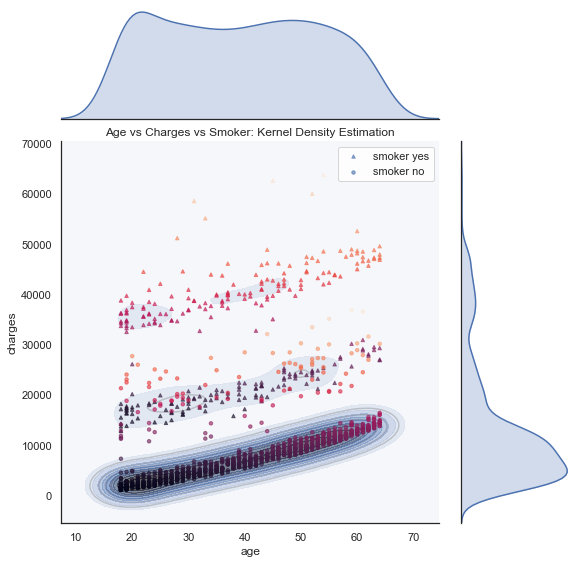

In [12]:
###KDE Age
sns.set(style="white", color_codes=True)
sns.jointplot('age', y_colname, data=dataset, kind="kde", color="b", height=8, ratio=3, alpha=0.6
              ,joint_kws = {'scatter_kws':dict(alpha=0.5)}
              ).plot_joint(sns.kdeplot, zorder=0, n_levels=6, alpha=0.5)
plt.scatter(dataset.loc[dataset['smoker'] == 'yes']['age'], dataset.loc[dataset['smoker'] == 'yes'][y_colname], c = dataset.loc[dataset['smoker'] == 'yes'][y_colname],alpha = 0.6, s = 12, marker ="^", label = 'smoker yes')
plt.scatter(dataset.loc[dataset['smoker'] == 'no']['age'], dataset.loc[dataset['smoker'] == 'no'][y_colname], c = dataset.loc[dataset['smoker'] == 'no'][y_colname],alpha = 0.6, s = 12, marker = 'o', label = 'smoker no')
plt.title('Age vs Charges vs Smoker: Kernel Density Estimation')
plt.legend()


This graph give us a quick information about the data density between Age, Charges and Smoker (triangles = smoker_yes). 
- We can see that the majority of the data is condensed in the bottom cluster, low charges and non smoker. 
- The top cluster is only smoker with high charges, 
- The middle cluster is a mix of smoker and non-smokers with moderate charges. We can already say that the model will have some difficulties with the middle cluster as it is mixed up ! 

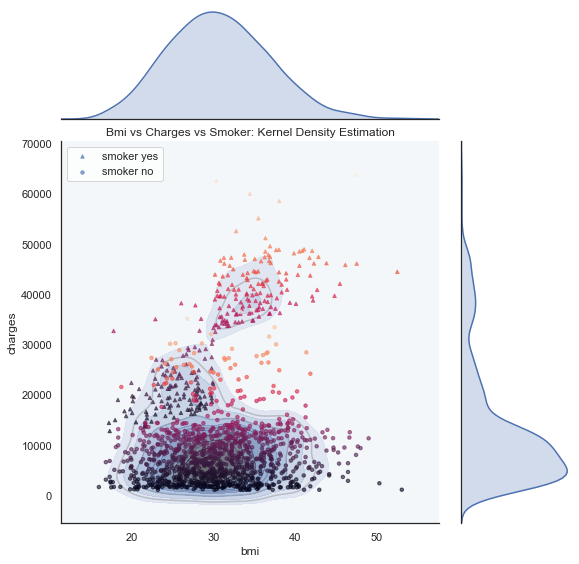

In [13]:
###KDE Bmi
sns.set(style="white", color_codes=True)
sns.jointplot('bmi', y_colname, data=dataset, kind="kde", color="b", height=8, ratio=3, alpha=0.6
              ,joint_kws = {'scatter_kws':dict(alpha=0.5)}
              ).plot_joint(sns.kdeplot, zorder=0, n_levels=6, alpha=0.5)
plt.scatter(dataset.loc[dataset['smoker'] == 'yes']['bmi'], dataset.loc[dataset['smoker'] == 'yes'][y_colname], c = dataset.loc[dataset['smoker'] == 'yes'][y_colname],alpha = 0.6, s = 12, marker ="^", label = 'smoker yes')
plt.scatter(dataset.loc[dataset['smoker'] == 'no']['bmi'], dataset.loc[dataset['smoker'] == 'no'][y_colname], c = dataset.loc[dataset['smoker'] == 'no'][y_colname],alpha = 0.6, s = 12, marker = 'o', label = 'smoker no')
plt.title('Bmi vs Charges vs Smoker: Kernel Density Estimation')
plt.legend()

If we do the same graph with bmi,
- The top cluster have only smokers, with high charges and moderate-high bmi
- the middle cluster is again, a mixed-up of smokers and non-smokers with moderate charges and low-moderate bmi
- The bottom cluster is only non-smokers, with all kind of bmi

Text(0, 0.5, 'charges')

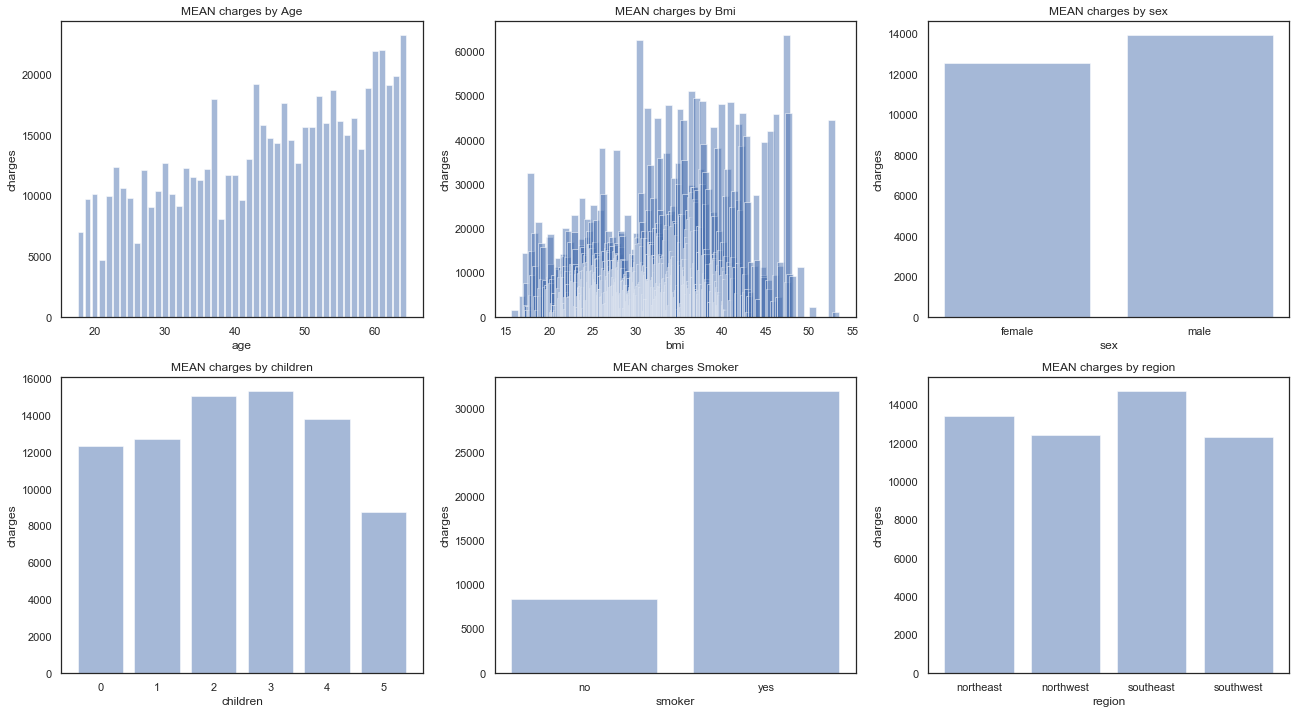

In [14]:
#MEAN CHARGES
f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(22, 12));
mean_charges_age = pd.DataFrame(dataset[['charges','age']].groupby(['age'], as_index=False).mean())
ax1.bar(mean_charges_age['age'].astype(int), mean_charges_age['charges'], alpha = 0.5)
ax1.set_title('MEAN charges by Age')
ax1.set_xlabel('age')
ax1.set_ylabel('charges')
#MEAN CHARGES BY BMI - barplot
mean_charges_bmi = pd.DataFrame(dataset[['charges','bmi']].groupby(['bmi'], as_index=False).mean())
ax2.bar(mean_charges_bmi['bmi'], mean_charges_bmi['charges'], alpha = 0.5)
ax2.set_title('MEAN charges by Bmi')
ax2.set_xlabel('bmi')
ax2.set_ylabel('charges')
#MEAN CHARGES BY SEX - barplot
mean_charges_sex = pd.DataFrame(dataset[['charges','sex']].groupby(['sex'], as_index=False).mean())
ax3.bar(mean_charges_sex['sex'], mean_charges_sex['charges'], alpha = 0.5)
ax3.set_title('MEAN charges by sex')
ax3.set_xlabel('sex')
ax3.set_ylabel('charges')
#MEAN CHARGES BY children - barplot
mean_charges_children = pd.DataFrame(dataset[['charges','children']].groupby(['children'], as_index=False).mean())
ax4.bar(mean_charges_children['children'], mean_charges_children['charges'], alpha = 0.5)
ax4.set_title('MEAN charges by children')
ax4.set_xlabel('children')
ax4.set_ylabel('charges')
#MEAN CHARGES BY SMOKER - barplot
mean_charges_smoker = pd.DataFrame(dataset[['charges','smoker']].groupby(['smoker'], as_index=False).mean())
ax5.bar(mean_charges_smoker['smoker'], mean_charges_smoker['charges'], alpha = 0.5)
ax5.set_title('MEAN charges Smoker')
ax5.set_xlabel('smoker')
ax5.set_ylabel('charges')
#MEAN CHARGES BY REGION - barplot
mean_charges_region = pd.DataFrame(dataset[['charges','region']].groupby(['region'], as_index=False).mean())
ax6.bar(mean_charges_region['region'], mean_charges_region['charges'], alpha = 0.5)
ax6.set_title('MEAN charges by region')
ax6.set_xlabel('region')
ax6.set_ylabel('charges')

This graph give us more information about the mean charges:
- Mean charges goes up with ages
- Mean charges goes up than goes down with bmi
- Mean charges is a little bit higher for male
- Mean charges is a little bit higher when 2 and 3 childrens
- Mean charges is a lot higher when smoker = Yes
- Mean charges is a ittle bit higher for the southeast region

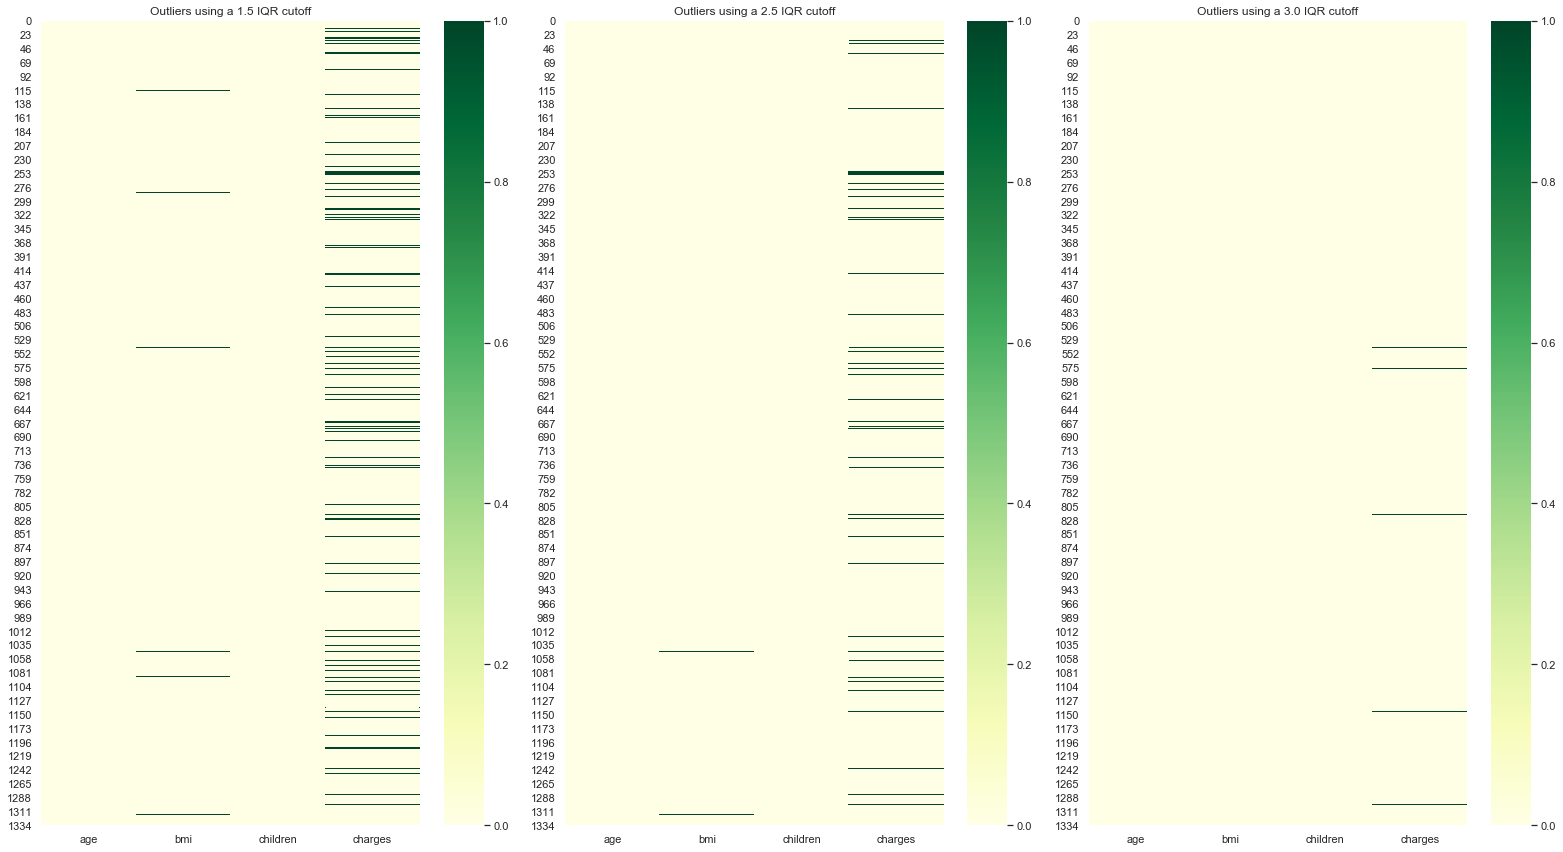

In [15]:
#OUTLIER ANALYSIS
iqr1 = dataset[colnames_numerical].apply(outlier_iqr, k=1.5)
iqr2 = dataset[colnames_numerical].apply(outlier_iqr, k=2.0)
iqr3 = dataset[colnames_numerical].apply(outlier_iqr, k=3.0)
#OUTLIER PLOT
f, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(22, 12));
ax1.set_title('Outliers using a 1.5 IQR cutoff');
ax2.set_title('Outliers using a 2.5 IQR cutoff');
ax3.set_title('Outliers using a 3.0 IQR cutoff');
sns.heatmap(iqr1, cmap='YlGn', ax=ax1);
sns.heatmap(iqr2, cmap='YlGn', ax=ax2);
sns.heatmap(iqr3, cmap='YlGn', ax=ax3);
plt.tight_layout()

This graph shows us the outliers, by numerical features. we can see that with the IQR method, there are few rows that are more than 3 IQR that we will clean later in the dataset.

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


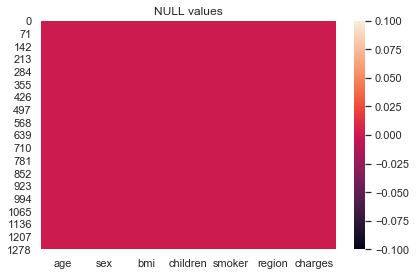

In [16]:
#NULL ANALYSIS
print(dataset.isnull().sum())
sns.heatmap(dataset.isnull(), cbar=True)
plt.title('NULL values')
plt.tight_layout()

Finally, the NULL analysis: Lucky us ! No NULL values to clean !

To conclude this quick EDA step;
- smoker_yes seems to be the most correlated features with charges. When smoker_yes = 1, charges seems to be a lot higher. This is a discrimant feature!
- The age and bmi follow smoker_yes as the most correlated features with charges. When the age is higher, the charges seems to be higher. There are also some evident data clusters when we look at charges by age and by bmi.
- The male sex seems to have slightly higher charges than female.
- The southeast region seems to have slightly higher charges than other regions.
- The rest of features seems to have a minor effect on the charges.
- They seems to have some multicolinearity between the regions and the bmi features.


## Data preparation
We have some basic cleaning to do before going anywhere with it.

For that, I will use a custom tool package that I have built. 

The DataPreparator class will automaticly do these few steps:
- replace_null (numerical = Mean, categorical = Mode)
- drop_duplicate_columns
- drop_duplicate_rows (without the predicator)
- drop_constant_columns
- drop_outliers (we can change the strategy but here, we will use an IQR >= 3)
- categorical_encoding (we can change the strategy but here, we will use basic dummy encoding)


If you want to know more about how it is done, you can have a look at the fboost.py, in the DataPreparator class code section.

**IMPORTANT NOTE: This fboost.py package is a quick implementation done for this demonstration, it is not bullet proof and may contains a lot of bugs ! Be aware if you use it for other purpose than this experimentation !**

In [17]:
#DATA SPLIT
X = dataset[dataset.columns.difference([y_colname])]
y = dataset[[y_colname]]
feature_names = list(dataset.columns.difference([y_colname]))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify = X['smoker'], 
                                                    random_state=0)

#DATA CLEANING
data_prep = DataPreparator(outliers_strategy = 'IQR', 
                           outliers_cutoff = 3, 
                           encoding_strategy = 'dummy')
#FIT CLEANING
X_train, y_train = data_prep.fit_transform(X_train, y_train)

#APPLY CLEANING ON TEST (Only for the categorial encoding part and null replace, will keep all the rows !)
X_test = data_prep.transform(X_test, y_test)

In [18]:
X_train.head(5)

,age,bmi,children,region_northwest,region_southeast,region_southwest,sex_male,smoker_yes
954,34,27.835,1,1,0,0,1,1
951,51,42.900,2,0,1,0,1,1
335,64,34.500,0,0,0,1,1,0
957,24,26.790,1,1,0,0,1,0
454,32,46.530,2,0,1,0,1,0


As we can see, the categorical features are now numerical with binary values.

If you are new to this and want to know what is dummy encoding or why we discarded one dummy variable for each categorical variables, go to this link (Quick explanation): 
<a href="https://www.statisticssolutions.com/dummy-coding-the-how-and-why/">dummy_encoding_link</a> 
    
        

In [19]:
#DATA SCALING FOR LINEAR REGRESSION ONLY (TREE DON'T NEED SCALING AS IT GENERATES RULES)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index = X_train.index, columns = list(X_train.columns))
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = list(X_test.columns))


# Linear Regression vs XGBoost BEFORE feature engineering

Let's start with the most simple regression model of all: Linear Regression

In [20]:
"""
#############################################
# 4-LINEAR REGRESSION MODEL WITHFEATURE ENGINEERING #
#############################################
"""

model = LinearRegression()
model.fit(X_train_scaled, y_train)
r2_linreg_before = model.score(X_test_scaled, y_test)
rmse_linreg_before = np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))
#print('R2:' + str(round(r2_linreg_before, 4)) + ', RMSE:' + str(round(rmse_linreg_before, 2)))

In [21]:
print('LinearRegression R2 (Before feature engineering): ' + str(round(r2_linreg_before, 4)))
print('LinearRegression RMSE (Before feature engineering): ' + str(round(rmse_linreg_before, 4)))

LinearRegression R2 (Before feature engineering): 0.7805
LinearRegression RMSE (Before feature engineering): 5631.4485


let's see how the simplified 2D decision function looks:

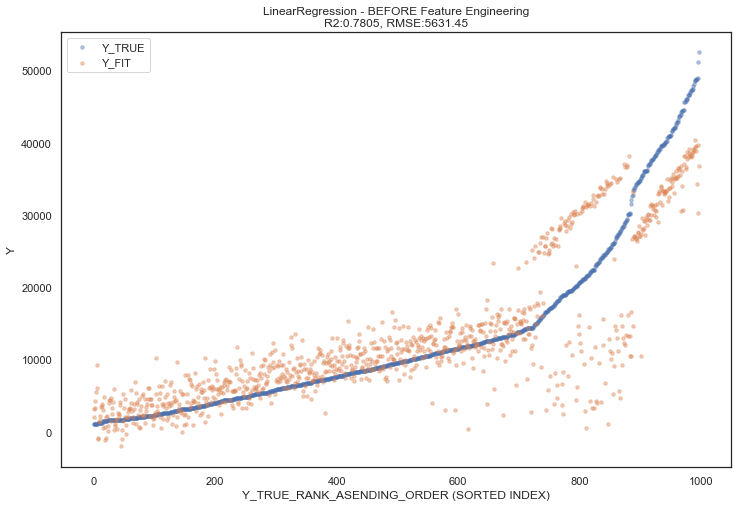

In [22]:
fit_results = pd.DataFrame(y_train.copy())
fit_results.columns = ['Y_TRUE']
test_pred_results = pd.DataFrame(y_test.copy())
test_pred_results.columns = ['Y_TRUE']

fit_results['Y_FIT'] = model.predict(X_train_scaled).ravel()
test_pred_results['Y_PRED'] = model.predict(X_test_scaled)

fit_results = fit_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)
test_pred_results = test_pred_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)

#### SCATTER PLOT
plt.figure(figsize=(12,8))
plt.scatter(fit_results.index,  fit_results['Y_TRUE'], alpha = 0.4, s = 12, label = 'Y_TRUE')
plt.scatter(fit_results.index,  fit_results['Y_FIT'], alpha = 0.4, s = 12, label = 'Y_FIT')
plt.xlabel('Y_TRUE_RANK_ASENDING_ORDER (SORTED INDEX)')
plt.ylabel('Y')
plt.title('LinearRegression - BEFORE Feature Engineering' + '\n' + 'R2:' + str(round(r2_linreg_before, 4)) + ', RMSE:' + str(round(rmse_linreg_before, 2)))
plt.legend()



This multivariate regression visualization trick is explained in detail with python codes in one of my previous article: 
Visualization trick for multivariate regression problems

Just by looking at the graph, we can spot a couple of problems (underfitting) in this Multivariate Linear Regression model. 

An instinctive basic solution to this problem would be: Let’s use a non-linear model instead! let’s try with the notrious XGBoost and see how it goes. We can cheat and use GridSearch to find an optimal hyper-parameters setting for the model:


In [23]:
"""
#############################################
# 4-XGBOOST MODEL WITHOUT FEATURE ENGINEERING #
#############################################
"""

#### GRID SEARCH
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [40,50,80,100],
        'learning_rate': [0.1, 0.01],
        'random_state': [0]
        }
model = XGBRegressor()

grid = GridSearchCV(estimator=model, 
                    param_grid=params, 
                    scoring='neg_root_mean_squared_error', 
                    n_jobs=8, 
                    cv=3, 
                    verbose=3 )
grid.fit(X_train,y_train)
print(grid.best_estimator_)

#With GridSearch Best Hyper-parameters 
model = XGBRegressor(min_child_weight = 10,
                     gamma = 0.5,
                     subsample = 1.0,
                     learning_rate = 0.1,
                     colsample_bytree = 1.0,
                     max_depth = 3,
                     n_estimators = 50,
                     random_state = 0)
model.fit(X_train, y_train)
r2_xgb_before = model.score(X_test, y_test)
rmse_xgb_before = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print('R2:' + str(round(r2_xgb_before, 4)) + ', RMSE:' + str(round(rmse_xgb_before, 2)))

Fitting 3 folds for each of 3240 candidates, totalling 9720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 912 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 1808 tasks      | elapsed:   16.1s
[Parallel(n_jobs=8)]: Done 2960 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done 4368 tasks      | elapsed:   37.6s
[Parallel(n_jobs=8)]: Done 6032 tasks      | elapsed:   53.7s
[Parallel(n_jobs=8)]: Done 7952 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 9705 out of 9720 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done 9720 out of 9720 | elapsed:  1.5min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=10, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1.0, verbosity=1)
R2:0.8869, RMSE:4043.61


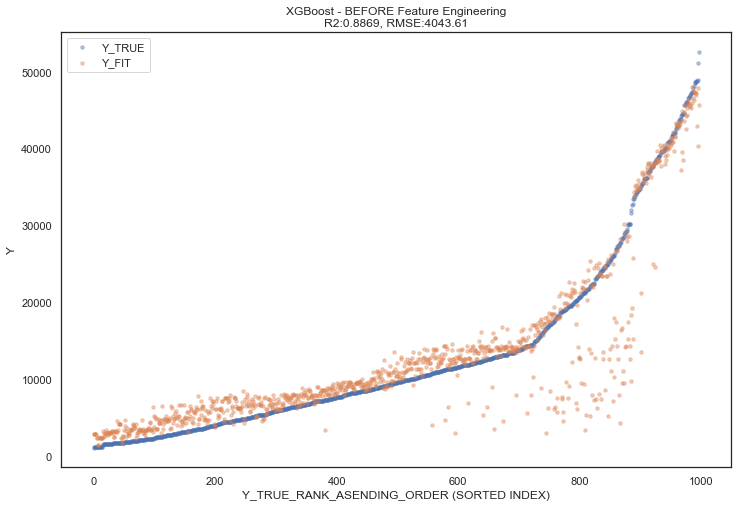

In [24]:
fit_results = pd.DataFrame(y_train.copy())
fit_results.columns = ['Y_TRUE']
test_pred_results = pd.DataFrame(y_test.copy())
test_pred_results.columns = ['Y_TRUE']

fit_results['Y_FIT'] = model.predict(X_train).ravel()
test_pred_results['Y_PRED'] = model.predict(X_test)

fit_results = fit_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)
test_pred_results = test_pred_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)

#### SCATTER PLOT
plt.figure(figsize=(12,8))
plt.scatter(fit_results.index,  fit_results['Y_TRUE'], alpha = 0.4, s = 12, label = 'Y_TRUE')
plt.scatter(fit_results.index,  fit_results['Y_FIT'], alpha = 0.4, s = 12, label = 'Y_FIT')
plt.xlabel('Y_TRUE_RANK_ASENDING_ORDER (SORTED INDEX)')
plt.ylabel('Y')
plt.title('XGBoost - BEFORE Feature Engineering' + '\n' + 'R2:' + str(round(r2_xgb_before, 4)) + ', RMSE:' + str(round(rmse_xgb_before, 2)))
plt.legend()

Wow! That’s gonna be hard to beat ! XGBoost performed a lot better than the Linear Regression model on this round ! The scores are:

In [25]:
print('XGBoost R2 (Before feature engineering): ' + str(round(r2_xgb_before, 4)))
print('XGBoost RMSE (Before feature engineering): ' + str(round(rmse_xgb_before, 4)))

XGBoost R2 (Before feature engineering): 0.8869
XGBoost RMSE (Before feature engineering): 4043.6107


This sound like Mission Impossible!, how the hell are we gonna engineer good features to beat those results with a simple Linear Regression model ??? 

In [26]:
print('We need at leat ' + str(round((abs(rmse_linreg_before - rmse_xgb_before) / rmse_linreg_before) * 100, 4)) + '%  of RMSE improvement… that seems HUGE !!!')  

We need at leat 28.1959%  of RMSE improvement… that seems HUGE !!!


# Implementing the feature engineering strategy

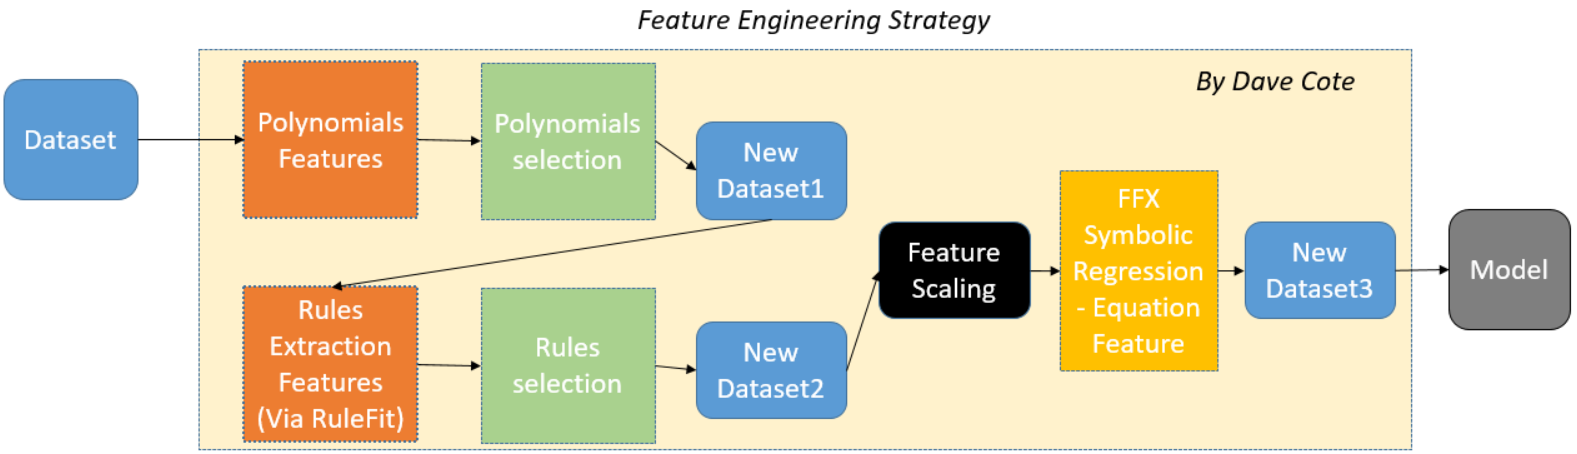

In [27]:
Image(filename = "FeatureEngineeringStrategy.png", width=1000, height=450)

This diagram is very important. this is the hole Feature Engineering strategy that we will use to Beat the XGBoost regression model.

Process description:
    
**1 - Polynomials features are created**. Second degree polynomials is enough. Then, we do a feature selection step to keep only the better ones. 

To be clear, we pass **ONLY** the polynomials features (Not the original ones) in the feature selection automated process.


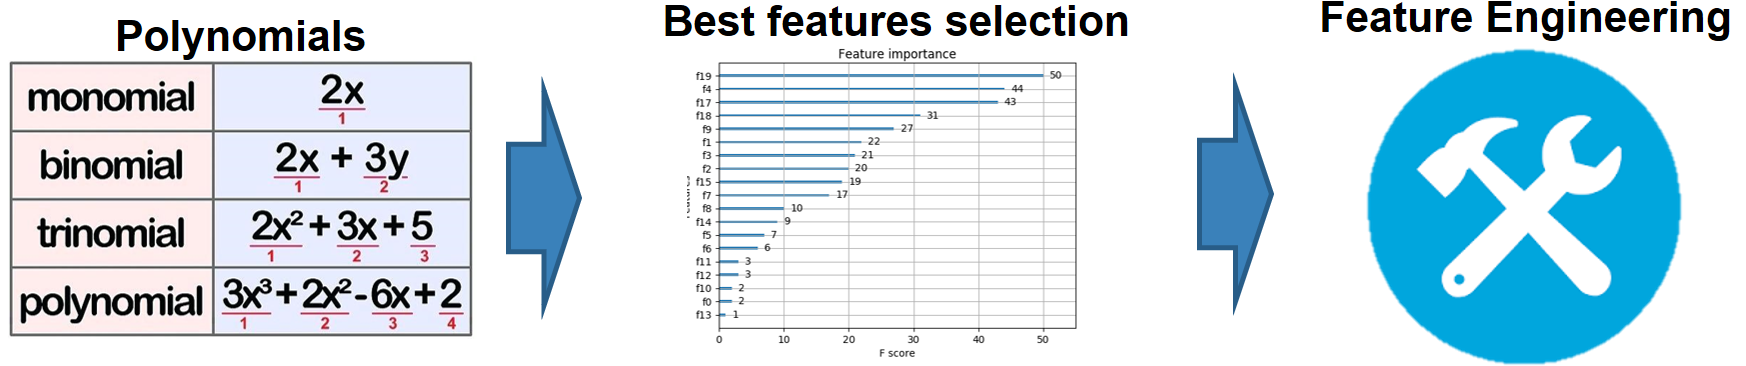

In [28]:
Image(filename = "polynomial_process.png", width=700, height=450)

**2 - Rules features are created using a RuleFit Ensembe model.** Then, we do a feature selection step to keep only the better rules.

To be clear, we pass **ONLY** the rules features (Not the original ones) in the feature selection automated process.

“RuleFit is not new.  It seems to have first appeared in a paper by Jerome Friedman and Bogdan Popescu of Stanford in October 2005 titled “Predictive Learning Via Rule Ensembles””. 

RuleFit is a very interesting underrated model and you can read more on it here:
<a href="https://www.datasciencecentral.com/profiles/blogs/using-rulefit-ensemble-models-is-about-to-become-very-important">RuleFit_important</a>
    
The original paper: 
<a href="http://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf">RuleFit_scientific_paper</a>
    
To be short, RuleFit is a Lasso linear model applied on extracted rules from a tree model or an ensemble tree model. We will use this model to extract the best rules of a Random Forest model and than, add those rules features to our dataset.

The python package I used for the RuleFit model is available on this github:
<a href="https://github.com/christophM/rulefit">RuleFit_github</a>

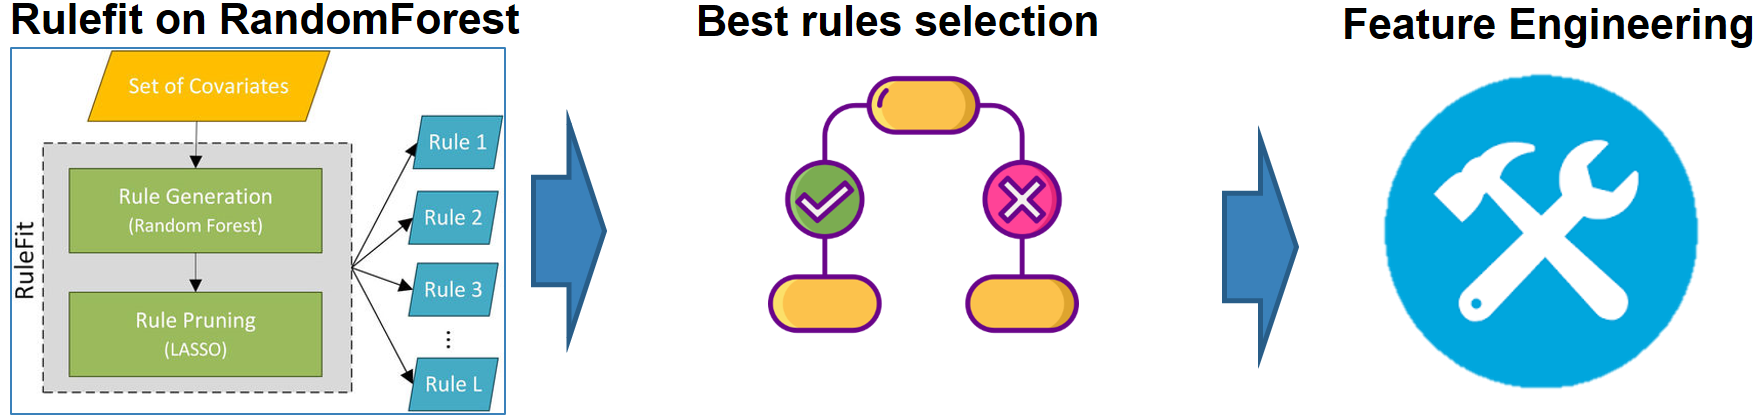

In [29]:
Image(filename = "rulefit_process.png", width=700, height=450)

The process to extract rules from RuleFit model and then convert them to python code to produce the new features is:

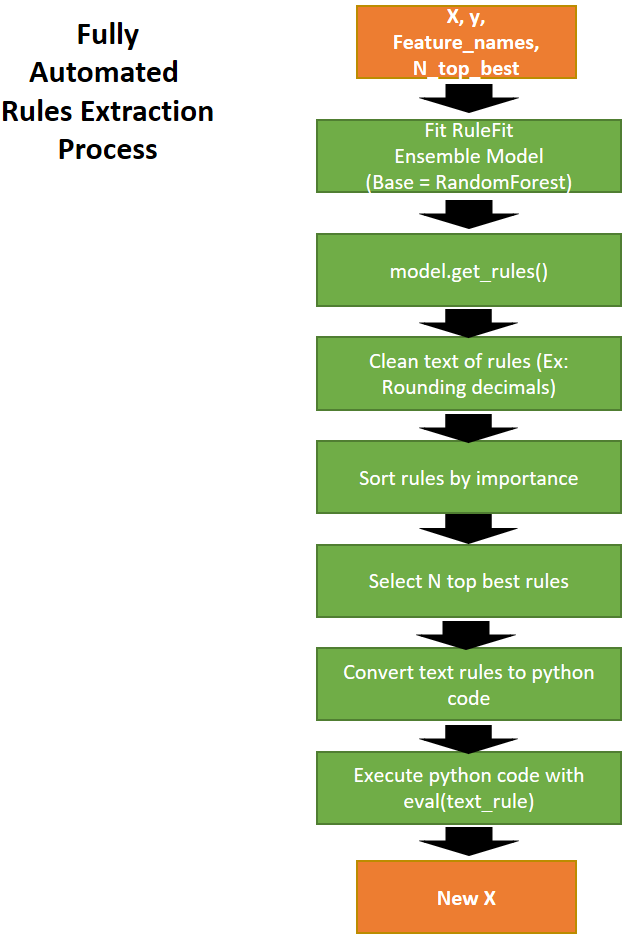

In [30]:
Image(filename = "rulefit_process2.png", width=450, height=450)  

Here is an example of the extracted rules dataframe created. Each rules have been converted to python code to create features that will be binary indicators (1 if the rule is applied on the row)

The feature selection technique used is custom. 
Here is the feature selection process implemented in fboost.py:

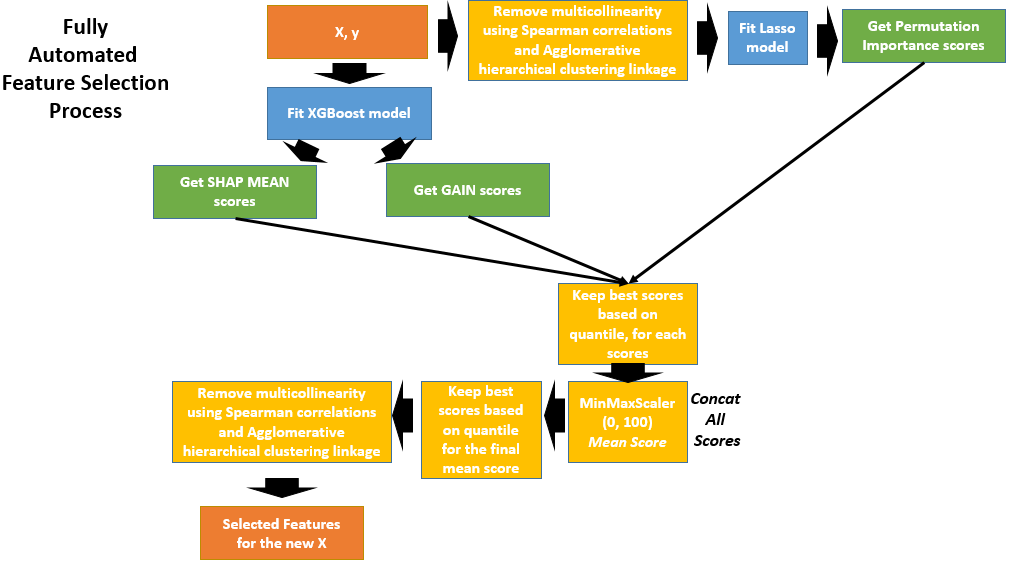

In [31]:
Image(filename = "feature_selection_process.png", width=900, height=450)    

There is a lot of thing happening in this automated feature selection process. If you are a new to any of these concepts, I invite you to read this:
- Shapley values: 
<a href="https://www.kdnuggets.com/2019/12/interpretability-part-3-lime-shap.html">shap_kdnuggets</a>,
<a href="https://christophm.github.io/interpretable-ml-book/lime.html">shap</a>

- Multicollinearity: 
<a href="https://www.statisticshowto.datasciencecentral.com/multicollinearity/">multicollinearity</a>

- Permutation Scores: 
<a href="https://www.kdnuggets.com/2019/12/interpretability-black-box-part-2.html">Permutation_Scores</a>

- Feature Importance Gain scores:
<a href="https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7">Feature_Importance_Tree</a>

- MinMax Scaling: 
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a>

- Agglomerative Hierarchical Clustering: 
<a href="https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html">permutation_multicollinear</a>,
<a href="https://www.datanovia.com/en/lessons/agglomerative-hierarchical-clustering/">agglomerative_HC</a>


The last Feature Engineering step is the FFX Symbolic Regression.

From wikipedia:
<a href="https://en.wikipedia.org/wiki/Symbolic_regression">Symbolic_Regressoin</a>

"Symbolic regression is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset, both in terms of accuracy and simplicity. 

No particular model is provided as a starting point to the algorithm. Instead, initial expressions are formed by randomly combining mathematical building blocks such as mathematical operators, analytic functions, constants, and state variables."

A great explanation is available here: 
<a href="https://towardsdatascience.com/ml-for-ts-2-symbolic-regression-26d5909cd1e8">Symbolic_Regressoin2</a>
    
"To be short, Symbolic Regression is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset"

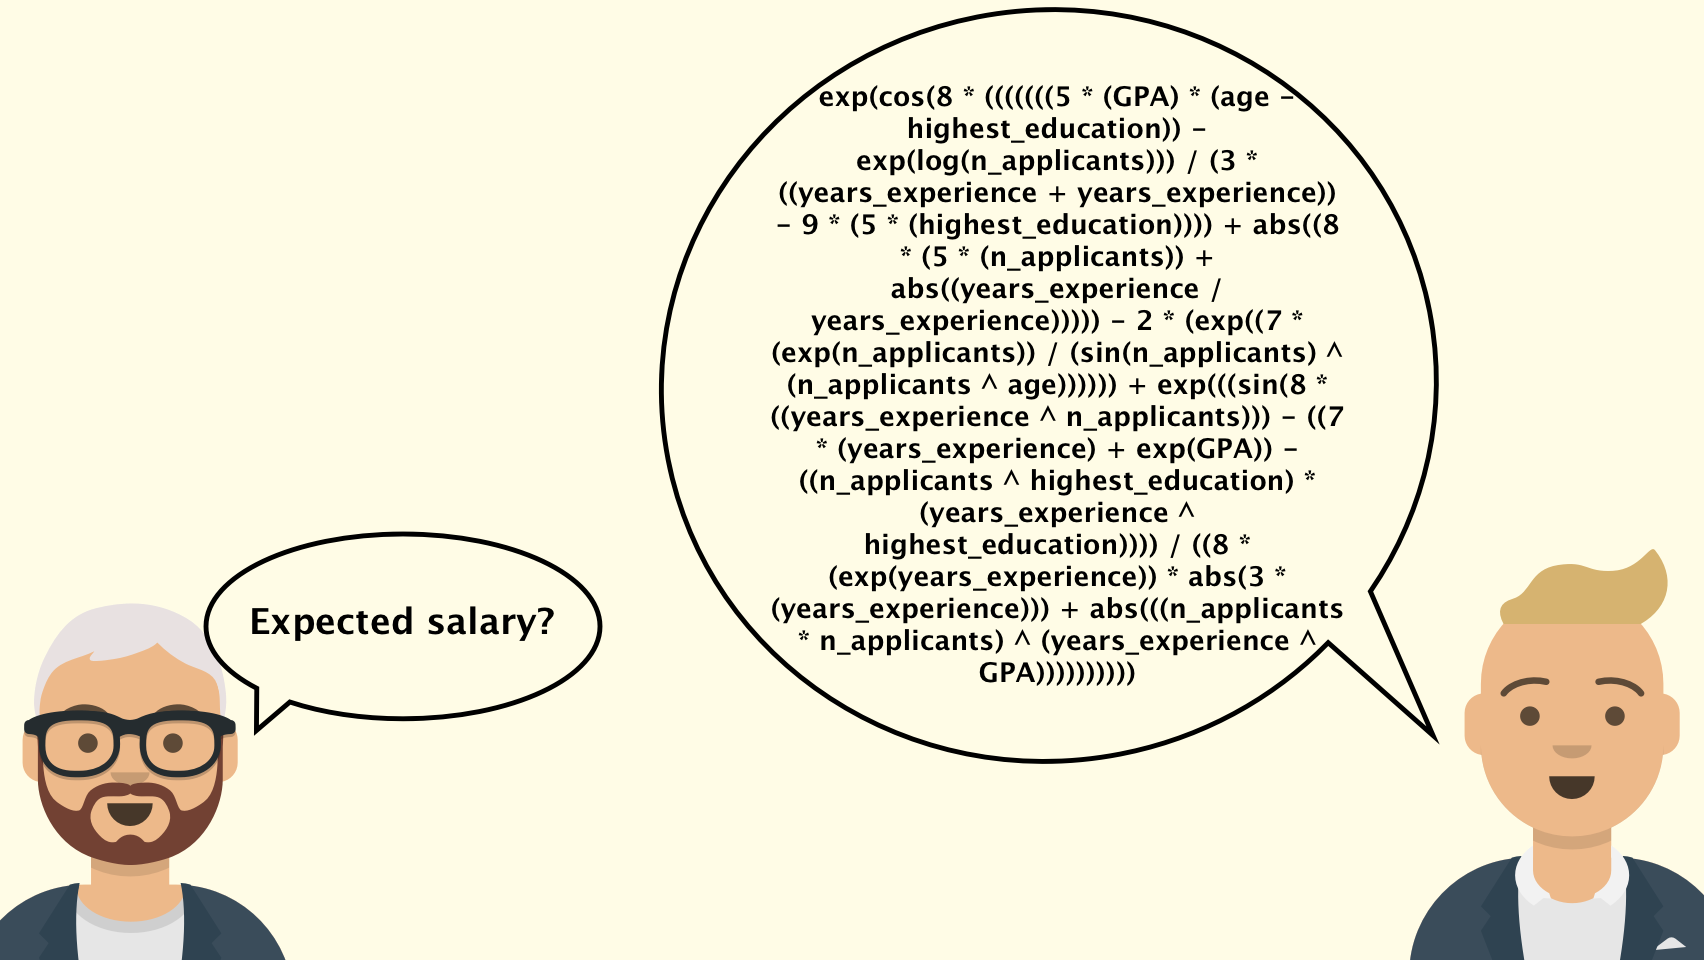

In [59]:
Image(filename = "symbolic_1.png", width=900, height=450)    

As explained here:
<a href="http://trent.st/ffx/">FFX</a>

FFX stands for Fast Function Extraction.

FFX is a technique for symbolic regression, to induce whitebox models given X/y training data. It does Fast Function Extraction. It is:

- Fast - runtime 5-60 seconds, depending on problem size (1GHz cpu)
- Scalable - 1000 input variables, no problem!
- Deterministic - no need to "hope and pray".

If you ignore the whitebox-model aspect, FFX can be viewed as a regression tool. It's been used this way for thousands of industrial problems with 100K+ input variables. It can also be used as a classifier (FFXC), by wrapping the output with a logistic map. This has also been used successfully on thousands of industrial problems.

The python package I use for the Feature Enginnering process is:
<a href="https://github.com/natekupp/ffx">FFX_github</a>

We will use this technic to extract the optimal function that explained charges from the feature in our dataset. Then, with the function given by the FFX model, we will create a last feature that is the result of applying the function on any new incoming data.

Let's first reset our data with the same data preparation we used before !

In [33]:
##############WITH FEATURE ENGINEERING

# Reload the dataset
dataset = pd.read_csv('insurance_kaggle.csv', sep = ',') 
y_colname = 'charges'

# SPLIT DATA
X = dataset[dataset.columns.difference([y_colname])]
y = dataset[[y_colname]]
feature_names = list(dataset.columns.difference([y_colname]))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify = X['smoker'], 
                                                    random_state=0)

# DATA PREP
data_prep = DataPreparator(outliers_strategy = 'IQR', 
                           outliers_cutoff = 3, 
                           encoding_strategy = 'dummy',
                           drop_duplicate_rows = True)
X_train, y_train = data_prep.fit_transform(X_train, y_train)
X_test = data_prep.transform(X_test, y_test)


Now, with the use of my custom fboost.py FeatureBoosterRegressor class, let automate the feature engineering process of polynomials, rules extraction and features selection:

In [34]:
# FEATURE ENGINEERING - 1/2 - Polynomials + Rules extraction
fboost = FeatureBoosterRegressor(base_model = RandomForestRegressor(criterion='friedman_mse', 
                                                    max_depth=5,
                                                    max_features=None, 
                                                    max_leaf_nodes=2,
                                                    min_samples_leaf=1, 
                                                    verbose=0, 
                                                    n_estimators = 850,
                                                    warm_start=True,
                                                    random_state = 0),
                                max_rules = 2800, 
                                n_best_rules = 35,
                                original_features_selection= False,
                                selection_strategy = 'severe',  
                                quantile_cutoff = 0.83,
                                alpha = 89,
                                scaler = 'Standard',
                                random_state = 0)

# FIT FEATURE ENGINEERING FOR TRAIN DATA
X_train, rules = fboost.fit_transform(X_train, y_train)

# TRANSFORM FEATURE ENGINEERING FOR TEST DATA
X_test = fboost.transform(X_test)



In [35]:
#LET HAVE A LOOK AT THE NEW FEATURES WE JUST CREATED
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 954 to 993
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               997 non-null    int64  
 1   bmi               997 non-null    float64
 2   children          997 non-null    int64  
 3   region_northwest  997 non-null    int32  
 4   region_southeast  997 non-null    int32  
 5   region_southwest  997 non-null    int32  
 6   sex_male          997 non-null    int32  
 7   smoker_yes        997 non-null    int32  
 8   bmi_smoker_yes    997 non-null    float64
 9   age2              997 non-null    float64
 10  age_children      997 non-null    float64
 11  RULE_EXTRACT_1    997 non-null    float64
 12  RULE_EXTRACT_18   997 non-null    float64
 13  RULE_EXTRACT_8    997 non-null    float64
dtypes: float64(7), int32(5), int64(2)
memory usage: 97.4 KB


We can see that we have added 3 Polynomials features: 
- bmi_smoker_yes (bmi * smoker_yes)
- age2 (age * age)
- age_children (age * children)

We have also added Rules features: 

In [36]:
selected_rules = fboost.rules_df_.loc[fboost.rules_df_['SELECTED'] == 1]
for row in range(0, len(selected_rules)):
    print(selected_rules.iloc[row, 0] + ': ' + selected_rules.iloc[row, 1])

RULE_EXTRACT_1: bmi_smoker_yes > 30.108 & bmi_smoker_yes > 26.05
RULE_EXTRACT_8: bmi_smoker_yes <= 27.721 & bmi_smoker_yes <= 8.591 & age2 <= 2652.5
RULE_EXTRACT_18: bmi_smoker_yes <= 26.05


Where did I get the rules ? After the FeatureBoosterRegressor FIT, we can have access to the rules_df_ dataframe:

In [37]:
fboost.rules_df_

,FEATURE_NAME,RULE,PYTHON_CODE,SELECTED
0,RULE_EXTRACT_1,bmi_smoker_yes > 30.108 & bmi_smoker_yes > 26.05,((data['bmi_smoker_yes'] > 30.108 ) & (data['b...,1
1,RULE_EXTRACT_2,age_children <= 19.5 & bmi_smoker_yes <= 30.10...,((data['age_children'] <= 19.5 ) & (data['bmi_...,0
2,RULE_EXTRACT_3,bmi_smoker_yes <= 30.108 & bmi_smoker_yes <= 1...,((data['bmi_smoker_yes'] <= 30.108 ) & (data['...,0
3,RULE_EXTRACT_4,bmi_smoker_yes > 28.305 & age > 27.5 & bmi > 3...,((data['bmi_smoker_yes'] > 28.305 ) & (data['a...,0
4,RULE_EXTRACT_5,bmi_smoker_yes <= 29.812 & age_children > 53.5...,((data['bmi_smoker_yes'] <= 29.812 ) & (data['...,0
5,RULE_EXTRACT_6,bmi_smoker_yes <= 28.433 & age <= 41.5,((data['bmi_smoker_yes'] <= 28.433 ) & (data['...,0
6,RULE_EXTRACT_7,bmi_smoker_yes <= 30.107 & age2 <= 1682.0 & bm...,((data['bmi_smoker_yes'] <= 30.107 ) & (data['...,0
7,RULE_EXTRACT_8,bmi_smoker_yes <= 27.721 & bmi_smoker_yes <= 8...,((data['bmi_smoker_yes'] <= 27.721 ) & (data['...,1
8,RULE_EXTRACT_9,age_children > 58.5 & bmi_smoker_yes <= 30.065...,((data['age_children'] > 58.5 ) & (data['bmi_s...,0
9,RULE_EXTRACT_10,age <= 32.5 & bmi_smoker_yes <= 18.295 & age_c...,((data['age'] <= 32.5 ) & (data['bmi_smoker_ye...,0


In [38]:
#DATA SCALING FOR LINEAR REGRESSION ONLY (TREE DON'T NEED SCALING AS IT GENERATES RULES)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index = X_train.index, columns = list(X_train.columns))
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = list(X_test.columns))

In [39]:
# FEATURE ENGINEERING - 2/2 - FFX Symbolic Regression, Extraction the function equation and apply it on train and test !
FFX = FFXRegressor()
FFX.fit(X_train_scaled.values, y_train.values.ravel())
print("Score:", FFX.score(X_test_scaled.values, y_test.values.ravel()))


Score: 0.8759002691138066


The score of the equation alone to explain the charges got an R2 > 0.80, wich is not bad at all and better than the original Linear Regression !

**Let's have a look at the Symbolic Regression Equation:**

In [40]:
equation = str(FFX.model_)
equation

'1.32e4 + 3.62e6*max(0,X10-2.84) * max(0,0.00720-X0) + 2.07e6*max(0,X10-1.49) * max(0,-0.592-X9) - 1.64e6*max(0,X10-1.49) * max(0,-0.427-X0) - 8.00e5*max(0,X10-2.17) * max(0,-0.427-X0) - 2.46e5*max(0,X10-2.17) * max(0,X0-1.31) + 1.86e5*max(0,X10-2.84) * max(0,X0-1.31) + 1.62e5*max(0,X10-1.49) * max(0,0.00720-X0) - 1.62e5*max(0,X2-2.70) * max(0,-0.592-X9) + 1.31e5*max(0,X10-1.49) * max(0,X9-1.63) + 1.30e5*max(0,X10-1.49) * max(0,X0-1.31) - 1.25e5*max(0,X2-2.70) * max(0,X0-0.876) + 1.23e5*max(0,X2-1.58) * max(0,X0-0.876) - 1.02e5*max(0,X10-2.17) * max(0,X0-0.876) - 1.02e5*max(0,X10-1.49) * max(0,-0.148-X9) - 8.43e4*max(0,X10-2.17) * max(0,X9-1.63) + 7.69e4*max(0,X2-1.58) * max(0,-0.592-X9) - 6.52e4*abs(X10) * max(0,X9-1.63) + 5.84e4*max(0,X10-2.84) * max(0,X0-0.876) + 5.61e4*max(0,X2-2.70) * max(0,0.00720-X0) - 5.34e4*max(0,X2-1.58) * max(0,-0.427-X0) - 5.19e4*max(0,X0+0.427) * max(0,0.00720-X0) - 5.16e4*max(0,X8-2.01) * max(0,X0-1.31) + 4.76e4*max(0,X8-2.01) * max(0,X9-1.63) + 4.50e4*ma

wow... whitebox but quite complicated!!! 

We will now clean this equation into python code and create a new feature with it !

In [41]:
# CLEAN THE EQUATION INTO PYTHON CODE, TO EXECUTE IT AND CREATE A NEW FEATURE !
equation = equation.replace('log10', 'np.log10')
equation = equation.replace('max', 'np.maximum')
equation = equation.replace('^2', '**2')
for i in range(0, len(X_train_scaled.columns)):
    equation = equation.replace('X'+str(i), "X_train_scaled['"+ X_train_scaled.columns.tolist()[i] + "'].values")
for i in range (0, 10):    
    equation = equation.replace('values'+str(i), 'values')
for i in range (0, 999):    
    if len(str(i)) == 1:
        pos = '0' + str(i)
    else:
        pos = str(i)
    equation = equation.replace('values'+pos, 'values')
for i in range (0, 999):    
    if len(str(i)) == 1:
        pos = '00' + str(i)
    else:
        pos = '0' + str(i)
    equation = equation.replace('values'+pos, 'values')

In [42]:
### APPLY THE SYMBOLIC REGRESSON EQUATION AND SCALE THE NEW FEATURE
scaler_ffx = StandardScaler()
X_train_scaled['FFX_SYMBOLIC_EQUATION'] = eval(equation)
X_train_scaled['FFX_SYMBOLIC_EQUATION'] = scaler_ffx.fit_transform(X_train_scaled[['FFX_SYMBOLIC_EQUATION']])
X_train['FFX_SYMBOLIC_EQUATION'] = X_train_scaled['FFX_SYMBOLIC_EQUATION']

X_test_scaled['FFX_SYMBOLIC_EQUATION'] = eval(equation.replace('X_train_scaled', 'X_test_scaled'))
X_test_scaled['FFX_SYMBOLIC_EQUATION'] = scaler_ffx.transform(X_test_scaled[['FFX_SYMBOLIC_EQUATION']])
X_test['FFX_SYMBOLIC_EQUATION'] = X_test_scaled['FFX_SYMBOLIC_EQUATION']

Let's have a look at our final dataset:

In [43]:
X_train_scaled.head(5)

,age,bmi,children,region_northwest,region_southeast,region_southwest,sex_male,smoker_yes,bmi_smoker_yes,age2,age_children,RULE_EXTRACT_1,RULE_EXTRACT_18,RULE_EXTRACT_8,FFX_SYMBOLIC_EQUATION
954,-0.380199,-0.474344,-0.093203,1.805736,-0.60787,-0.569243,0.979154,1.990025,1.719525,-0.523768,-0.198459,-0.341264,-2.376272,-1.206509,-0.026548
951,0.824510,1.987143,0.743941,-0.553791,1.64509,-0.569243,0.979154,1.990025,2.915010,0.753092,1.119859,2.930280,-2.376272,-1.206509,0.319645
335,1.745759,0.614658,-0.930346,-0.553791,-0.60787,1.756720,0.979154,-0.502506,-0.489326,2.074134,-0.857619,-0.341264,0.420827,-1.206509,0.016785
957,-1.088851,-0.645087,-0.093203,1.805736,-0.60787,-0.569243,0.979154,-0.502506,-0.489326,-1.036280,-0.392330,-0.341264,0.420827,0.828837,-0.119559
454,-0.521929,2.580252,0.743941,-0.553791,1.64509,-0.569243,0.979154,-0.502506,-0.489326,-0.640409,0.383152,-0.341264,0.420827,0.828837,-0.462858


In [44]:
X_train.head(5)

,age,bmi,children,region_northwest,region_southeast,region_southwest,sex_male,smoker_yes,bmi_smoker_yes,age2,age_children,RULE_EXTRACT_1,RULE_EXTRACT_18,RULE_EXTRACT_8,FFX_SYMBOLIC_EQUATION
954,34,27.835,1,1,0,0,1,1,27.835,1156.0,34.0,0.0,0.0,0.0,-0.026548
951,51,42.900,2,0,1,0,1,1,42.900,2601.0,102.0,1.0,0.0,0.0,0.319645
335,64,34.500,0,0,0,1,1,0,0.000,4096.0,0.0,0.0,1.0,0.0,0.016785
957,24,26.790,1,1,0,0,1,0,0.000,576.0,24.0,0.0,1.0,1.0,-0.119559
454,32,46.530,2,0,1,0,1,0,0.000,1024.0,64.0,0.0,1.0,1.0,-0.462858


In [45]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 954 to 993
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    997 non-null    float64
 1   bmi                    997 non-null    float64
 2   children               997 non-null    float64
 3   region_northwest       997 non-null    float64
 4   region_southeast       997 non-null    float64
 5   region_southwest       997 non-null    float64
 6   sex_male               997 non-null    float64
 7   smoker_yes             997 non-null    float64
 8   bmi_smoker_yes         997 non-null    float64
 9   age2                   997 non-null    float64
 10  age_children           997 non-null    float64
 11  RULE_EXTRACT_1         997 non-null    float64
 12  RULE_EXTRACT_18        997 non-null    float64
 13  RULE_EXTRACT_8         997 non-null    float64
 14  FFX_SYMBOLIC_EQUATION  997 non-null    float64
dtypes: f

To resume the feature engineering steps we just accomplished, we have created **NEW FEATURES**.

Each of them are whitebox and can be calculated with a linear formula (polynomials, rules or equation)

**We are now ready to beat the notorious XGBoost !!!!**

# Linear Regression vs XGBoost AFTER feature engineering

In [46]:
"""
#############################################
# 4-LINEAR REGRESSION MODEL WITHFEATURE ENGINEERING #
#############################################
"""

model_reg = LinearRegression()
model_reg.fit(X_train_scaled, y_train)
r2_linreg_after = model_reg.score(X_test_scaled, y_test)
rmse_linreg_after = np.sqrt(mean_squared_error(y_test, model_reg.predict(X_test_scaled)))
print('R2:' + str(round(r2_linreg_after, 4)) + ', RMSE:' + str(round(rmse_linreg_after, 2)))


R2:0.8921, RMSE:3948.02


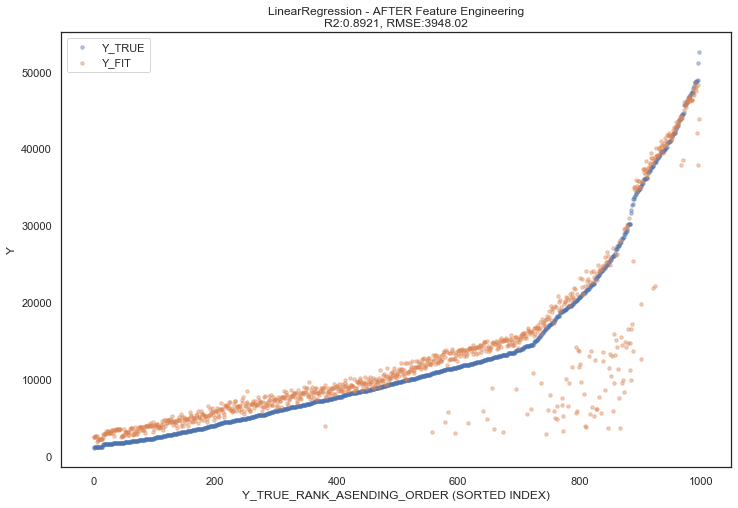

In [47]:
"""
#############################################
# 4-LINEAR REGRESSION VISUALIZE MODEL WITHFEATURE ENGINEERING #
#############################################
"""
fit_results = pd.DataFrame(y_train.copy())
fit_results.columns = ['Y_TRUE']
test_pred_results = pd.DataFrame(y_test.copy())
test_pred_results.columns = ['Y_TRUE']

fit_results['Y_FIT'] = model_reg.predict(X_train_scaled).ravel()
test_pred_results['Y_PRED'] = model_reg.predict(X_test_scaled)

fit_results = fit_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)
test_pred_results = test_pred_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)

#### SCATTER PLOT
plt.figure(figsize=(12,8))
plt.scatter(fit_results.index,  fit_results['Y_TRUE'], alpha = 0.4, s = 12, label = 'Y_TRUE')
plt.scatter(fit_results.index,  fit_results['Y_FIT'], alpha = 0.4, s = 12, label = 'Y_FIT')
plt.xlabel('Y_TRUE_RANK_ASENDING_ORDER (SORTED INDEX)')
plt.ylabel('Y')
plt.title('LinearRegression - AFTER Feature Engineering' + '\n' + 'R2:' + str(round(r2_linreg_after, 4)) + ', RMSE:' + str(round(rmse_linreg_after, 2)))
plt.legend()

# Boom! Mission accomplished!

We just beat both regression scores of the notorious XGboost  … with a simple Linear Regression model !

### XGBoost BEFORE:

In [48]:
print('XGBoost R2 (Before feature engineering): ' + str(round(r2_xgb_before, 4)))
print('XGBoost RMSE (Before feature engineering): ' + str(round(rmse_xgb_before, 4)))

XGBoost R2 (Before feature engineering): 0.8869
XGBoost RMSE (Before feature engineering): 4043.6107


### Linear Regression AFTER:

In [49]:
print('LinearRegression R2 (AFTER feature engineering): ' + str(round(r2_linreg_after, 4)))
print('LinearRegression RMSE (AFTER feature engineering): ' + str(round(rmse_linreg_after, 4)))

LinearRegression R2 (AFTER feature engineering): 0.8921
LinearRegression RMSE (AFTER feature engineering): 3948.016


Maybe the XGboost is now better than before with the new feature engineering process, let’s try it! (With a new GridSearch of course!):

In [50]:
"""
#############################################
# 4-XGBOOST MODEL WITH FEATURE ENGINEERING #
#############################################
"""

#### GRID SEARCH
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.3, 0.5, 1, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 60, 100, 300],
        'learning_rate': [0.1, 0.01],
        'random_state': [0]
        }
model = XGBRegressor()


grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=8, cv=3, verbose=3 )
grid.fit(X_train,y_train)
print(grid.best_estimator_)


model = XGBRegressor(min_child_weight = 5,
                     gamma = 0.3,
                     subsample = 0.8,
                     colsample_bytree = 0.6,
                     max_depth = 3,
                     learning_rate = 0.1,
                     n_estimators = 50,
                     random_state = 0)
model.fit(X_train, y_train)
r2_xgb_after = model.score(X_test, y_test)
rmse_xgb_after = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print('R2:' + str(round(r2_xgb_after, 4)) + ', RMSE:' + str(round(rmse_xgb_after, 2)))

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 208 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 976 tasks      | elapsed:   24.2s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   38.9s
[Parallel(n_jobs=8)]: Done 2256 tasks      | elapsed:   57.9s
[Parallel(n_jobs=8)]: Done 3088 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 4048 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 5136 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 6352 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 7696 tasks      | elapsed:  3.6min


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.3,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=5, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)
R2:0.885, RMSE:4076.53


[Parallel(n_jobs=8)]: Done 7776 out of 7776 | elapsed:  3.7min finished


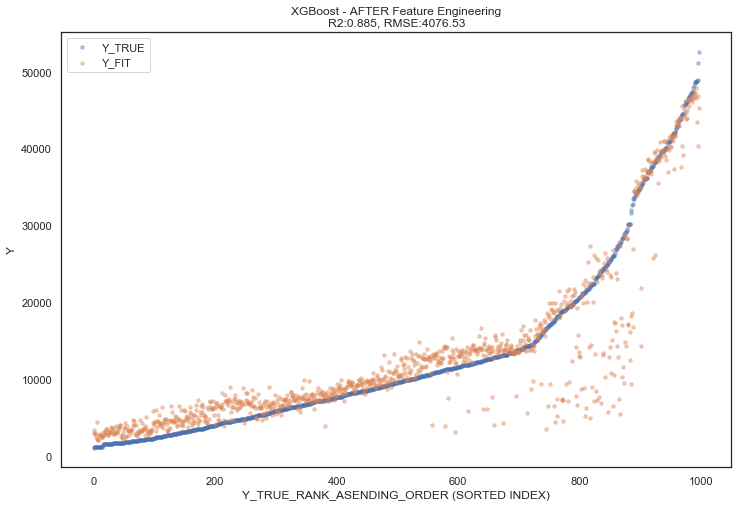

In [51]:
"""
#############################################
# 4-XGBOOST VISUALIZE MODEL WITH FEATURE ENGINEERING #
#############################################
"""
fit_results = pd.DataFrame(y_train.copy())
fit_results.columns = ['Y_TRUE']
test_pred_results = pd.DataFrame(y_test.copy())
test_pred_results.columns = ['Y_TRUE']

fit_results['Y_FIT'] = model.predict(X_train).ravel()
test_pred_results['Y_PRED'] = model.predict(X_test)

fit_results = fit_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)
test_pred_results = test_pred_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)

#### SCATTER PLOT
plt.figure(figsize=(12,8))
plt.scatter(fit_results.index,  fit_results['Y_TRUE'], alpha = 0.4, s = 12, label = 'Y_TRUE')
plt.scatter(fit_results.index,  fit_results['Y_FIT'], alpha = 0.4, s = 12, label = 'Y_FIT')
plt.xlabel('Y_TRUE_RANK_ASENDING_ORDER (SORTED INDEX)')
plt.ylabel('Y')
plt.title('XGBoost - AFTER Feature Engineering' + '\n' + 'R2:' + str(round(r2_xgb_after, 4)) + ', RMSE:' + str(round(rmse_xgb_after, 2)))
plt.legend()

# Boom! DOUBLE KILL - Mission accomplished twice !

Linear Regression model is still better ! the new added features only helped the Linear Regression, not the XGBoost model

Let's see the linear weights of the new Linear regression Model:

Text(0.5, 1, 'Linear Regression Weights, intercept: 13274.2275')

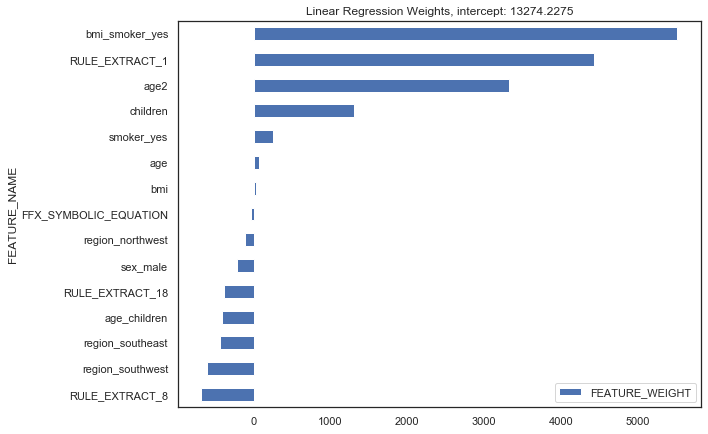

In [52]:
X_weights = pd.DataFrame(model_reg.coef_)
X_weights.columns = X_train_scaled.columns
X_weights = X_weights.T
X_weights.columns = ['FEATURE_WEIGHT']
X_weights['FEATURE_NAME'] = X_weights.index
X_weights.groupby(['FEATURE_NAME']).sum().sort_values(['FEATURE_WEIGHT']).plot.barh(figsize = (10,6))
plt.tight_layout()
plt.title('Linear Regression Weights, intercept: ' + str(round(model_reg.intercept_[0], 4)))


Text(0.5, 1, 'Linear Regression ABSOLUTE Weights, intercept: 13274.2275')

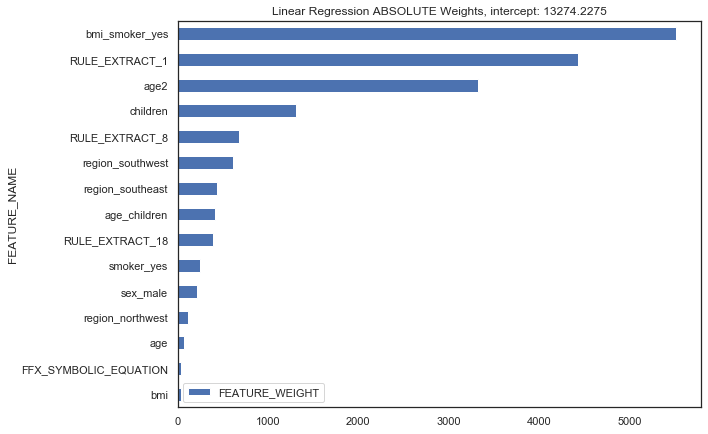

In [53]:
X_weights_abs = X_weights.groupby(['FEATURE_NAME']).sum().sort_values(['FEATURE_WEIGHT'])
X_weights_abs['FEATURE_WEIGHT'] = abs(X_weights_abs['FEATURE_WEIGHT'])
X_weights_abs = X_weights_abs.sort_values(['FEATURE_WEIGHT'])
X_weights_abs.plot.barh(figsize = (10,6))
plt.tight_layout()
plt.title('Linear Regression ABSOLUTE Weights, intercept: ' + str(round(model_reg.intercept_[0], 4)))

In this graph, we can see that the top 5 features with the highest importance are:

In [54]:
for row in range (0, 5):
    print('TOP ' + str(row+1) + ':' + str(X_weights_abs.sort_values(['FEATURE_WEIGHT'], ascending = False).iloc[row, :].name) + ', absolute weight: ' + str(round(X_weights_abs.sort_values(['FEATURE_WEIGHT'], ascending = False).iloc[row, 0], 4)) )

TOP 1:bmi_smoker_yes, absolute weight: 5521.3658
TOP 2:RULE_EXTRACT_1, absolute weight: 4433.0401
TOP 3:age2, absolute weight: 3325.6663
TOP 4:children, absolute weight: 1310.7841
TOP 5:RULE_EXTRACT_8, absolute weight: 679.8148


The FFX_SYMBOLIC_EQUATION feature have not added a lot of importance to the model... but it was easy to implement soo !

Here are the final results:

In [55]:
df_results = pd.DataFrame([['R2', r2_linreg_before, r2_xgb_before, r2_linreg_after, r2_xgb_after]], index = [0], columns = ['METRIC', 'LINEAR_REGRESSION_BEFORE', 'XGBOOST_BEFORE', 'LINEAR_REGRESSION_AFTER','XGBOOST_AFTER'])
df_results = df_results.append(pd.DataFrame([['RMSE', rmse_linreg_before, rmse_xgb_before, rmse_linreg_after, rmse_xgb_after]], index = [1], columns = ['METRIC', 'LINEAR_REGRESSION_BEFORE', 'XGBOOST_BEFORE', 'LINEAR_REGRESSION_AFTER','XGBOOST_AFTER']))
df_results

,METRIC,LINEAR_REGRESSION_BEFORE,XGBOOST_BEFORE,LINEAR_REGRESSION_AFTER,XGBOOST_AFTER
0,R2,0.780550,0.886855,0.892142,0.885006
1,RMSE,5631.448532,4043.610728,3948.015997,4076.528881


If we want to go further, we can still keep our model linear but add regularization to it. Let's see if a regularized linear model will be more powerfull than a non-regularized linear regression (Lasso):

In [56]:
"""
#############################################
# L1 REGULARIZED LINEAR REGRESSION (LASSO) MODEL WITHFEATURE ENGINEERING #
#############################################
"""

model_reg = Lasso(alpha = 89)
model_reg.fit(X_train_scaled, y_train)
r2_lasso_after = model_reg.score(X_test_scaled, y_test)
rmse_lasso_after = np.sqrt(mean_squared_error(y_test, model_reg.predict(X_test_scaled)))
print('R2:' + str(round(r2_lasso_after, 4)) + ', RMSE:' + str(round(rmse_lasso_after, 2)))

R2:0.8929, RMSE:3934.78


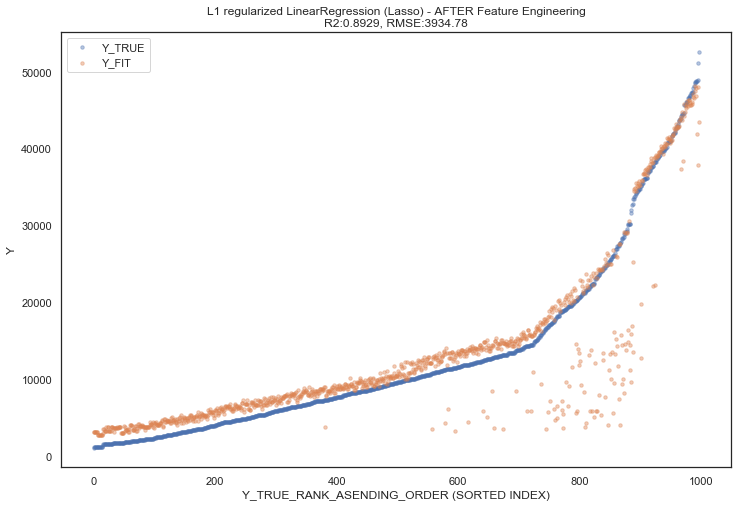

In [57]:
"""
#############################################
# L1 REGULARIZED LINEAR REGRESSION (LASSO)  VISUALIZE MODEL WITHFEATURE ENGINEERING #
#############################################
"""
fit_results = pd.DataFrame(y_train.copy())
fit_results.columns = ['Y_TRUE']
test_pred_results = pd.DataFrame(y_test.copy())
test_pred_results.columns = ['Y_TRUE']

fit_results['Y_FIT'] = model_reg.predict(X_train_scaled).ravel()
test_pred_results['Y_PRED'] = model_reg.predict(X_test_scaled)

fit_results = fit_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)
test_pred_results = test_pred_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)

#### SCATTER PLOT
plt.figure(figsize=(12,8))
plt.scatter(fit_results.index,  fit_results['Y_TRUE'], alpha = 0.4, s = 12, label = 'Y_TRUE')
plt.scatter(fit_results.index,  fit_results['Y_FIT'], alpha = 0.4, s = 12, label = 'Y_FIT')
plt.xlabel('Y_TRUE_RANK_ASENDING_ORDER (SORTED INDEX)')
plt.ylabel('Y')
plt.title('L1 regularized LinearRegression (Lasso) - AFTER Feature Engineering' + '\n' + 'R2:' + str(round(r2_lasso_after, 4)) + ', RMSE:' + str(round(rmse_lasso_after, 2)))
plt.legend()

# YES!! The linear model is even better with L1 regularization !

In [58]:
df_results2 = pd.DataFrame([['R2', r2_linreg_before, r2_xgb_before, r2_linreg_after, r2_xgb_after, r2_lasso_after]], index = [0], columns = ['METRIC', 'LINEAR_REGRESSION_BEFORE', 'XGBOOST_BEFORE', 'LINEAR_REGRESSION_AFTER','XGBOOST_AFTER', 'LASSO_AFTER'])
df_results2 = df_results2.append(pd.DataFrame([['RMSE', rmse_linreg_before, rmse_xgb_before, rmse_linreg_after, rmse_xgb_after, rmse_lasso_after]], index = [1], columns = ['METRIC', 'LINEAR_REGRESSION_BEFORE', 'XGBOOST_BEFORE', 'LINEAR_REGRESSION_AFTER','XGBOOST_AFTER', 'LASSO_AFTER']))
df_results2

,METRIC,LINEAR_REGRESSION_BEFORE,XGBOOST_BEFORE,LINEAR_REGRESSION_AFTER,XGBOOST_AFTER,LASSO_AFTER
0,R2,0.780550,0.886855,0.892142,0.885006,0.892864
1,RMSE,5631.448532,4043.610728,3948.015997,4076.528881,3934.780306


# Conclusion

Sometimes, going forward with a more complex model or skipping the feature engineering step to hyper-parameters tuning is not always the best move to make. Linear models are often UNDERRATED

As a data science practitioner, I think we should pass a lot more time on feature engineering. It is easy to be lazy and go fast with a more complex and popular model like the XGboost. 

Of course, I'm not crazy or blind; when we are in a big complex data situation, linear models could fail very badly, even with a good feature engineering !, XGBoost / Deep neural networks are still gold nuggets in that kind of situations ! And with **SHAPLEY VALUES** there is no black box anymore. We can get the feature importance from a Deep Neural Network if we want.  

### CREATIVITY: This should be the most important asset of any data science practitioners, not a PHD ! there are much more to do then a simple SPLIT/FIT/PRED process... There are unlimited ressources and tools out there, it is yours to be creative with them !

What is nice about going linear is that now, I don't need a model anymore. I can just calculate the new features with the equations, apply the linear weights and that's it !

Also, the RuleFit is a powerful underrated model with a lot of application. You should deep dive on that !

Like I promised in my first part, I demonstrated again the power of feature engineering but this time, with a much more complicated dataset and by defeating XGBoost.
    
I hope this article have been interesting / useful to you !

# Dave Cote, Data Scientist, M.Sc. BI
